### 3. Prediction and Evaluation

***
#### Model Benchmarking and Performance Evaluation
This script performs a comprehensive quantitative evaluation of ProtoGTX on the test set (CPTAC benchmark).

In [ ]:
BASE_DIR = '/workspace/HDDX/Pathology_Graph'
from __future__ import absolute_import, division, print_function

import os
os.chdir(f'{BASE_DIR}/github/PathoGraphX')

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

import sys
sys.path.append(f'{BASE_DIR}/github/PathoGraphX')
from dataset_module.graph_dataset import ConceptGraphDataset
from protogtx.helper import Trainer, Evaluator, collate
from protogtx.ConceptGraphTransformer import Classifier

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--n_class', type=int, default=3)
parser.add_argument('--data_path', type=str, default="./splits/CPTAC/graphs")
parser.add_argument('--expl_path', type=str, default="./splits/CPTAC/split_0/expl_16x16")
parser.add_argument('--val_set', type=str, default="./splits/CPTAC/split_0/test_set.txt")
parser.add_argument('--save_dir', type=str, default="./example/results/")
parser.add_argument('--task_name', type=str, default="GraphCAM" )
parser.add_argument('--site', type=str, default='LUAD')
parser.add_argument('--batch_size', type=int, default=8)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--n_features', type=int, default=1536)
parser.add_argument('--resume', type=str, default=f"./example/results/model_checkpoint.pth", help='path for model')
parser.add_argument('--log_interval_local', type=int, default=10)
parser.add_argument('--graphcam', action='store_true', default=False, help='GraphCAM')
args = parser.parse_args(args=[])

train = False
test = True
args.graphcam = False

torch.cuda.synchronize()
torch.backends.cudnn.deterministic = True

data_path = args.data_path
expl_path = args.expl_path
task_name = args.task_name

class_dict = {'normal': 0, 'luad': 1, 'lscc': 2}
ids_val = open(args.val_set).readlines()
dataset_val = ConceptGraphDataset(root=data_path,
                                  root2=expl_path,
                                  ids=ids_val,
                                  site=args.site,
                                  classdict=class_dict)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=args.batch_size, num_workers=0, 
                            collate_fn=collate, shuffle=False, pin_memory=True)
total_val_num = len(dataloader_val) * args.batch_size
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
##### creating models #############
print("creating models......")

num_epochs = args.num_epochs
learning_rate = args.lr

if args.graphcam:
    model = Classifier(n_class=args.n_class,
                    n_features=args.n_features,
                    expl_w=5.0,
                    graphcam_dir=args.save_dir+'GraphCAM/',)
else:
    model = Classifier(n_class=args.n_class, n_features=args.n_features, expl_w=5.0,)
model = nn.DataParallel(model)
if args.resume:
    print('load model{}'.format(args.resume))
    model.load_state_dict(torch.load(args.resume))

if torch.cuda.is_available():
    model = model.cuda()

evaluator = Evaluator(args.n_class)
with torch.no_grad():
    model.eval()
    print("evaluating...")

    total = 0.
    batch_idx = 0

    for i_batch, sample_batched in enumerate(dataloader_val):
        preds, labels, cls_loss, expl_loss, concept_attn = evaluator.eval_test(sample_batched, model, n_features=args.n_features, graphcam_flag=args.graphcam)
        
        total += len(labels)

        evaluator.metrics.update(labels, preds)

        if (i_batch + 1) % args.log_interval_local == 0:
            print('[%d/%d] val agg acc: %.3f' % (total, total_val_num, evaluator.get_scores()))
            evaluator.plot_cm()

    print('[%d/%d] val agg acc: %.3f' % (total_val_num, total_val_num, evaluator.get_scores()))
    evaluator.plot_cm()

from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

cm = evaluator.metrics.confusion_matrix
y_true, y_pred = [], []
for i in range(len(cm)):
    for j in range(len(cm)):
        y_true += [i] * int(cm[i, j])
        y_pred += [j] * int(cm[i, j])

# --- Eval ---
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("Confusion Matrix:\n", cm)
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bacc:.4f}")
print(f"F1 (macro):        {f1_macro:.4f}")
print(f"F1 (micro):        {f1_micro:.4f}")
print(f"F1 (weighted):     {f1_weighted:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro):    {recall:.4f}")

creating models......
load model./example/results/model_checkpoint.pth
evaluating...


/tmp/ipykernel_704809/3864114957.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.resume))
/workspace/HDDX/Pathology_Graph/github/P

[80/208] val agg acc: 0.988
[[27.  0.  0.]
 [ 0. 27.  0.]
 [ 0.  1. 25.]]
[160/208] val agg acc: 0.988
[[53.  1.  0.]
 [ 0. 53.  0.]
 [ 0.  1. 52.]]
[208/208] val agg acc: 0.986
[[73.  2.  0.]
 [ 0. 64.  0.]
 [ 0.  1. 68.]]
Confusion Matrix:
 [[73.  2.  0.]
 [ 0. 64.  0.]
 [ 0.  1. 68.]]
Accuracy:          0.9856
Balanced Accuracy: 0.9863
F1 (macro):        0.9854
F1 (micro):        0.9856
F1 (weighted):     0.9857
Precision (macro): 0.9851
Recall (macro):    0.9863


***
#### Model Evaluation and Interpretability Visualization
This script evaluates the ProtoGTX framework on a representative Lung Adenocarcinoma (LUAD) case from the CPTAC dataset. It generates dual-modality visualizations to interpret the model's diagnostic reasoning.

creating models......
load model./example/results/model_checkpoint.pth
evaluating...


/tmp/ipykernel_704809/663571126.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.resume))
/workspace/HDDX/Pathology_Graph/github/Pa

GraphCAM enabled

Creating heatmap for: 
Top Left:  (0, 0) Bottom Right:  (45815, 46936)
Width: 2863, Height: 2933
Original Patch Size / Scaled Patch Size: (512, 512) / [32 32]


/workspace/HDDX/Pathology_Graph/github/PathoGraphX/protogtx/ConceptGraphTransformer.py:129: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = F.softmax(out)


vis_level:  1
downsample:  16
region_size:  (2863, 2933)
total of 2929 patches


100%|██████████| 2929/2929 [00:00<00:00, 12118.97it/s]


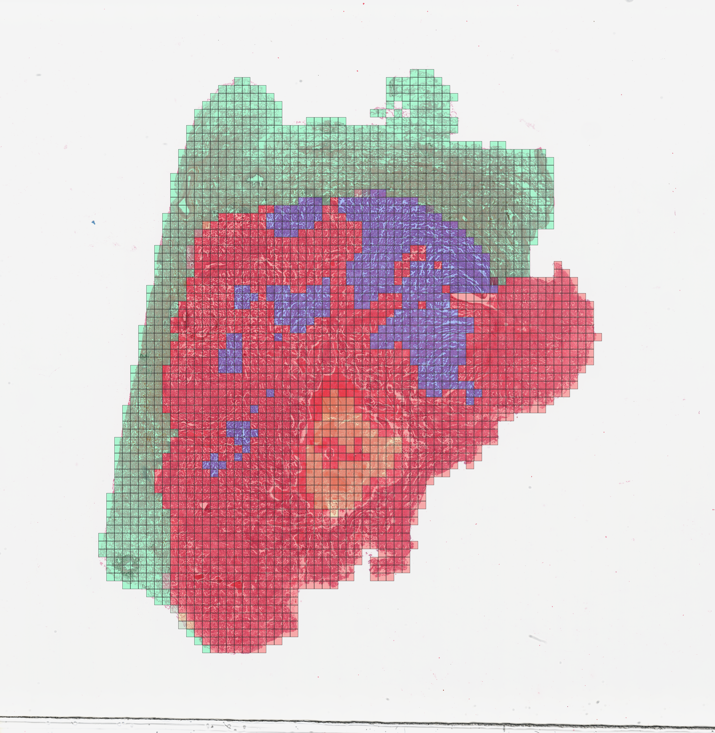

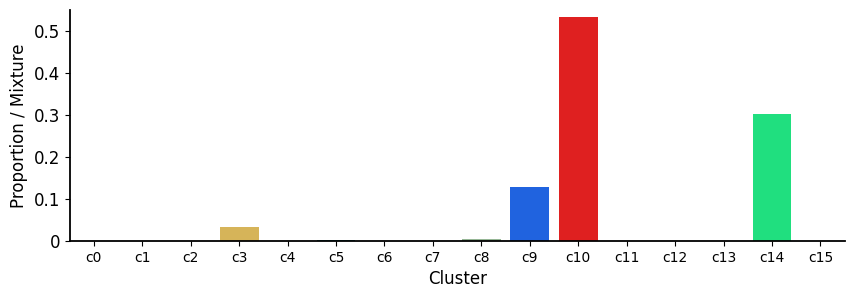

/workspace/HDDX/Pathology_Graph/github/PathoGraphX/visualization/graphcam_vis_utils.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  p = torch.load(self.graphcam_path+'/

visualize GraphCAM


/workspace/HDDX/Pathology_Graph/github/PathoGraphX/visualization/graphcam_vis_utils.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  assign_matrix = torch.load(self.grap

In [ ]:
from visualization import proto_vis_utils, graphcam_vis_utils

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--n_class', type=int, default=3)
parser.add_argument('--data_path', type=str, default="./splits/CPTAC/graphs")
parser.add_argument('--expl_path', type=str, default="./splits/CPTAC/split_0/expl_16x16")
parser.add_argument('--val_set', type=str, default="./splits/CPTAC/split_0/test_set.txt")
parser.add_argument('--save_dir', type=str, default="./example/results/")
parser.add_argument('--task_name', type=str, default="GraphCAM" )
parser.add_argument('--site', type=str, default='LUAD')
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--num_epochs', type=int, default=50)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--n_features', type=int, default=1536)
parser.add_argument('--resume', type=str, default=f"./example/results/model_checkpoint.pth", help='path for model')
parser.add_argument('--log_interval_local', type=int, default=10)
parser.add_argument('--graphcam', action='store_true', default=False, help='GraphCAM')
args = parser.parse_args(args=[])

train = False
test = True
args.graphcam = True

torch.cuda.synchronize()
torch.backends.cudnn.deterministic = True

data_path = args.data_path
expl_path = args.expl_path
task_name = args.task_name

class_dict = {'normal': 0, 'luad': 1, 'lscc': 2}
ids_val = open(args.val_set).readlines()
dataset_val = ConceptGraphDataset(root=data_path,
                                  root2=expl_path,
                                  ids=ids_val,
                                  site=args.site,
                                  classdict=class_dict)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=args.batch_size, num_workers=0, 
                            collate_fn=collate, shuffle=False, pin_memory=True)
total_val_num = len(dataloader_val) * args.batch_size
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
##### creating models #############
print("creating models......")

num_epochs = args.num_epochs
learning_rate = args.lr

if args.graphcam:
    model = Classifier(n_class=args.n_class,
                    n_features=args.n_features,
                    expl_w=5.0,
                    graphcam_dir=args.save_dir+'GraphCAM/',)
else:
    model = Classifier(n_class=args.n_class, n_features=args.n_features, expl_w=5.0,)
model = nn.DataParallel(model)
if args.resume:
    print('load model{}'.format(args.resume))
    model.load_state_dict(torch.load(args.resume))

if torch.cuda.is_available():
    model = model.cuda()

# evaluation settings
wsi_dirs = ['/workspace/HDDX/Pathology_datasource/PKG-CPTAC-LUAD_v12/LUAD/',
            '/workspace/HDDX/Pathology_datasource/PKG-CPTAC-LSCC_v10/LSCC/',]

h5_feats_dirs=[f'/workspace/HDDX/Pathology_Graph/datasource/CPTAC/LUAD_CLAM/patch_512/uni_features/feats_h5/',
               f'/workspace/HDDX/Pathology_Graph/datasource/CPTAC/LSCC_CLAM/patch_512/uni_features/feats_h5/']

vis_dat = proto_vis_utils.VisP2PAttn(
    wsi_dirs=wsi_dirs,
    h5_feats_dirs=h5_feats_dirs,
    patch_size=512,
    downsample=32,
    n_prototypes=16,
)
gcam_dat = graphcam_vis_utils.VisGraphCAM(
    wsi_dirs=wsi_dirs,
    h5_feats_dirs=h5_feats_dirs,
    graphcam_path=args.save_dir+'GraphCAM/',
    vis_save_dir=args.save_dir+'GraphCAM_vis/',
    class_dict=class_dict,
    stack_auto=False,
)

colors = [
    '#696969','#556b2f','#a0522d',"#EBBE448D", 
    '#008000','#008b8b','#000080','#7f007f',
    '#8fbc8f',"#0059ff",'#ff0000','#ffa500',
    "#030303",'#8a2be2','#00ff7f','#FFFF54', 
    '#00ffff','#00bfff','#f4a460','#adff2f',
    '#da70d6',"#111924",'#ff00ff','#1e90ff',
    '#f0e68c','#0000ff','#dc143c','#90ee90',
    '#ff1493','#7b68ee','#ffefd5','#ffb6c1'
]

evaluator = Evaluator(args.n_class)
with torch.no_grad():
    model.eval()
    print("evaluating...")


    for i_batch, sample_batched in enumerate(dataloader_val):
        if sample_batched['id'][0] not in ['C3N-01416-23']:
            continue
        preds, labels, cls_loss, expl_loss, concept_attn = evaluator.eval_test(sample_batched, model, n_features=args.n_features, graphcam_flag=args.graphcam)
        
        vis_dat.visualize_attn(sample_batched['id'][0], concept_attn, ind=0, colors=colors, alpha=0.3)
        gcam_dat.visualize_graphcam(sample_batched, n_class=3, patch_size=512, ind=0)

        break